### **FINGERS: Counting Fingers And Distinguishing Between Left And Right**

## 配置环境

使用colab( https://colab.research.google.com )，在“代码执行程序中”选择“更改运行时类型”，在“硬件加速器”中选择“GPU”。

我们选择从Kaggle里面下载数据，所以需要安装对应的库。没有本地上传，因为太大了，Google云端硬盘会直接卡死。

In [ ]:
!pip install Kaggle

Import libraries

In [ ]:
import tensorflow as tf
from zipfile import ZipFile
import os,glob
from skimage.io import imread
from skimage.transform import resize 
import matplotlib.pyplot as plt
import random
import warnings
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util
from skimage import io
from sklearn import metrics
from tqdm.notebook import tqdm_notebook as tqdm
import numpy as np
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from keras.layers import LeakyReLU
from numpy import asarray
from google.colab import files
from zipfile import ZipFile
import cv2
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from numpy import *

下载数据


You need to first add a kaggle.json file which you will get by creating a new API token on Kaggle. Go to my account in Kaggle and scroll down you would see an option for creating a new API. Once you click on that a file ‘kaggle.json’ will be downloaded.

In [ ]:
files.upload() # 上传了包含我的kaggle账户信息的json数据

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json 
!kaggle datasets download -d koryakinp/fingers

解压文件

In [ ]:
file_name = "fingers.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

至此，我们的环境已经配置完成。

## 处理数据集

使用Opencv进行图像处理放入相应的数据集

In [ ]:
X_train = [] # 训练图像集
Y_train = [] # 训练标签集
os.chdir('/content/train')
print("Train:")
for i in tqdm(os.listdir()): # 一张一张图片处理，显示进度条
  img = cv2.imread(i) # 读入图片 
  X_train.append(img) # 加入图像训练集
  Y_train.append(i[-6:-4]) # 根据文件名提取标签加入标签训练集
print("Shape of an image in X_train: ", X_train[0].shape) # 输入训练数据维度
print("Total categories: ", len(np.unique(Y_train))) # 训练集种类数

X_test = [] # 测试图像集
Y_test = [] # 测试标签集
os.chdir('/content/test')
print("Test:")
for i in tqdm(os.listdir()):
  img = cv2.imread(i)   
  X_test.append(img)
  Y_test.append(i[-6:-4]) 
print("Shape of an image in X_test: ", X_test[0].shape) # 输入测试数据维度
print("Total categories: ", len(np.unique(Y_test))) # 测试集种类数

Train:


  0%|          | 0/18000 [00:00<?, ?it/s]

Shape of an image in X_train:  (128, 128, 3)
Total categories:  12
Test:


  0%|          | 0/3600 [00:00<?, ?it/s]

Shape of an image in X_test:  (128, 128, 3)
Total categories:  12


数据集举例

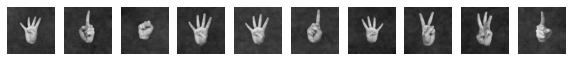

label for each of the above image: ['4R', '1L', '0R', '4R', '4R', '1R', '4L', '2L', '3L', '1R']


In [ ]:
%matplotlib inline
plt.figure(figsize=(10, 1))
for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.imshow(X_test[i], cmap="gray")
  plt.axis('off')
plt.show()
print('label for each of the above image: %s' % (Y_test[0:10]))

处理数据集

In [ ]:
# 标签序列化，把12个种类用0-11表示
le = preprocessing.LabelEncoder()  
Y_train = le.fit_transform(Y_train) 
Y_test = le.fit_transform(Y_test) 

# 标签集矩阵化：每个标签对应一个12维向量，它是第n类，那么第n维为1，其他维为0
Y_train = tf.keras.utils.to_categorical(Y_train, num_classes=12)
Y_test = tf.keras.utils.to_categorical(Y_test, num_classes=12)

# list->array
Y_train = np.array(Y_train)
X_train = np.array(X_train)
Y_test = np.array(Y_test)
X_test = np.array(X_test)

## 搭建神经网络

优化前的神经网络（为了测试结果时，此段可以不用运行）

In [ ]:
def create_original_CNN():
  myCNN = Sequential()
  myCNN.add(BatchNormalization(input_shape=(128,128,3))) # 数据预处理：标准化
  myCNN.add(Convolution2D(filters=32, kernel_size=3, padding='same', activation='relu')) 
  myCNN.add(MaxPooling2D(pool_size=2))
  myCNN.add(Convolution2D(filters=6, kernel_size=4, padding='same', activation='relu'))
  myCNN.add(MaxPooling2D(pool_size=2))
  myCNN.add(Convolution2D(filters=128, kernel_size=3, padding='same', activation='relu'))
  myCNN.add(MaxPooling2D(pool_size=2))
  myCNN.add(Convolution2D(filters=128, kernel_size=2, padding='same', activation='relu'))
  myCNN.add(MaxPooling2D(pool_size=2))
  myCNN.add(Flatten()) 
  myCNN.add(Dense(units=128, activation='relu'))
  myCNN.add(Dense(units=64, activation='relu'))
  myCNN.add(Dense(units=32, activation='relu'))
  myCNN.add(Dense(units=12, activation='softmax'))
  myCNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

优化后的神经网络

In [ ]:
def create_CNN():
  # The sequential API allows you to create models layer-by-layer for most problems. 
  # It is limited in that it does not allow you to create models that share layers or have multiple inputs or outputs.
  myCNN = Sequential()
  num_filter = 6
  myCNN.add(BatchNormalization(input_shape=(128,128,3))) # 数据预处理：标准化
  myCNN.add(Convolution2D(filters=num_filter, kernel_size=3, padding='same', activation='leaky_relu')) 
  myCNN.add(MaxPooling2D(pool_size=2)) 
  myCNN.add(Convolution2D(filters=num_filter, kernel_size=3, padding='same', activation='leaky_relu')) 
  myCNN.add(MaxPooling2D(pool_size=2))
  myCNN.add(Flatten())
  myCNN.add(Dense(units=12, activation='softmax'))
  myCNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return myCNN

参数优化实验代码：cross-validation（为了测试结果时，此段可以不用运行）

In [ ]:
X_folds = np.array_split(X_train, 10)
Y_folds = np.array_split(Y_train, 10)
scores = list()
for k in range(10):
    # We use 'list' to copy, in order to 'pop' later on
    x_train = list(X_folds)
    x_test = x_train.pop(k)
    x_train = np.concatenate(x_train)
    y_train = list(Y_folds)
    y_test = y_train.pop(k)
    y_train = np.concatenate(y_train)
    myCNN = create_CNN()
    model = myCNN.fit(x_train, y_train, epochs=1, verbose=1, initial_epoch=0)
    loss_and_metrics = myCNN.evaluate(X_test, Y_test)
    scores.append(loss_and_metrics[0])
print("scores: ", scores)
print("平均", mean(scores))

训练

In [ ]:
myCNN = create_CNN()
model = myCNN.fit(X_train, Y_train, epochs=1, verbose=1, initial_epoch=0)

## 测试结果

测试

In [ ]:
loss_and_metrics = myCNN.evaluate(X_test, Y_test, batch_size=1)
print(loss_and_metrics)

3600/3600 [==============================] - 10s 3ms/step - loss: 0.0025 - accuracy: 0.9997
[0.002505379030480981, 0.9997222423553467]


从测试集中随机输入图像到模型中，看看输出的分类结果是否真的有这么高

In [ ]:
predicted_classes = myCNN.predict(X_test[:,:,:,:])
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
predicted_classes[0]
k=X_test.shape[0]
r=np.random.randint(k)
print(r)
print("Prediction:",predicted_classes[r])
print("\nActuals:   ",Y_test[r])

746
Prediction: 7

Actuals:    [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
